# Canadian Employment Income and Educational Qualifications Analysis

## Overview
This notebook analyzes the relationship between educational qualifications and employment income in Canada. The analysis provides insights for government agencies, educational institutions, research organizations, and employers.

### Key Objectives
1. Analyze graduation rates, demographic trends, and popular fields of study
2. Identify correlations between graduate characteristics and employment outcomes
3. Segment graduates into meaningful clusters
4. Build predictive models for employment income and graduation likelihood
5. Provide actionable insights for stakeholders

### Dataset Description
The dataset includes the following key columns:
- REF_DATE: Time period of the data
- GEO: Geographic location
- Educational qualification
- Field of study
- Gender
- Age group
- Status of student
- Characteristics after graduation
- VALUE: Median employment income

In [19]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Import custom utility functions
from utils import detect_anomalies, build_recommendation_system, assess_fairness, build_lstm_model, simulate_policy_impact
from advanced_analysis import analyze_demographic_trends, visualize_correlations, perform_feature_selection, explain_predictions, evaluate_model_performance

## Data Loading and Cleaning
In this section, we load the dataset and perform necessary cleaning operations:
- Handle missing values through appropriate imputation
- Remove duplicates and outliers
- Encode categorical variables
- Normalize numerical features

In [21]:
def load_and_clean_data(file_path):
    """Load and clean the dataset with error handling and logging."""
    try:
        # Load data
        df = pd.read_csv(file_path)
        print(f'Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns')
        
        # Basic cleaning
        df = df.drop_duplicates()
        print(f'Removed {df.shape[0] - len(df)} duplicate rows')
        
        # Handle missing values
        missing_stats = df.isnull().sum()
        print('\nMissing value statistics:')
        print(missing_stats[missing_stats > 0])
        
        # Impute missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        for col in numeric_cols:
            df[col].fillna(df[col].median(), inplace=True)
        for col in categorical_cols:
            df[col].fillna(df[col].mode()[0], inplace=True)
            
        # Encode categorical variables
        le = LabelEncoder()
        for col in categorical_cols:
            df[col + '_encoded'] = le.fit_transform(df[col])
            
        # Normalize numerical features
        scaler = StandardScaler()
        df[numeric_cols + '_scaled'] = scaler.fit_transform(df[numeric_cols])
        
        return df
    
    except FileNotFoundError:
        print(f'Error: File not found at {file_path}')
        return None
    except Exception as e:
        print(f'Error during data loading and cleaning: {str(e)}')
        return None

# Load and clean the dataset
file_path = '37100114.csv'  # Update with actual file path
df = load_and_clean_data(file_path)

if df is not None:
    print('\nDataset Summary:')
    print(df.info())
    print('\nSample of cleaned data:')
    display(df.head())

Dataset loaded successfully with 1048575 rows and 21 columns
Removed 0 duplicate rows

Missing value statistics:
VALUE          189718
STATUS         858857
SYMBOL        1048575
TERMINATED    1048575
dtype: int64

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 42 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   REF_DATE                                  1048575 non-null  int64  
 1   GEO                                       1048575 non-null  object 
 2   DGUID                                     1048575 non-null  object 
 3   Educational qualification                 1048575 non-null  object 
 4   Field of study                            1048575 non-null  object 
 5   Gender                                    1048575 non-null  object 
 6   Age group                                 1048575 non-null  object

,REF_DATE,GEO,DGUID,Educational qualification,Field of study,Gender,Age group,Status of student in Canada,Characteristics after graduation,Graduate statistics,...,VECTOR_encoded,COORDINATE_encoded,STATUS_encoded,REF_DATE_scaled,UOM_ID_scaled,SCALAR_ID_scaled,VALUE_scaled,SYMBOL_scaled,TERMINATED_scaled,DECIMALS_scaled
0,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,All graduates,Number of graduates,...,0,0,1,-1.067403,-0.595183,0.0,14.122108,NaN,NaN,0.0
1,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,Graduates with no income information,Number of graduates,...,1,1,1,-1.067403,-0.595183,0.0,1.487970,NaN,NaN,0.0
2,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,Full-time students,Number of graduates,...,2,2,1,-1.067403,-0.595183,0.0,1.048545,NaN,NaN,0.0
3,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,Graduates reporting employment income,Number of graduates,...,3,3,1,-1.067403,-0.595183,0.0,10.930661,NaN,NaN,0.0
4,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,"Graduates reporting wages, salaries and commis...",Number of graduates,...,4,4,1,-1.067403,-0.595183,0.0,9.489725,NaN,NaN,0.0


## Exploratory Data Analysis (EDA)
This section explores the relationships and patterns in our data through:
- Distribution analysis of key variables
- Temporal trends in employment income
- Demographic correlations
- Geographic patterns

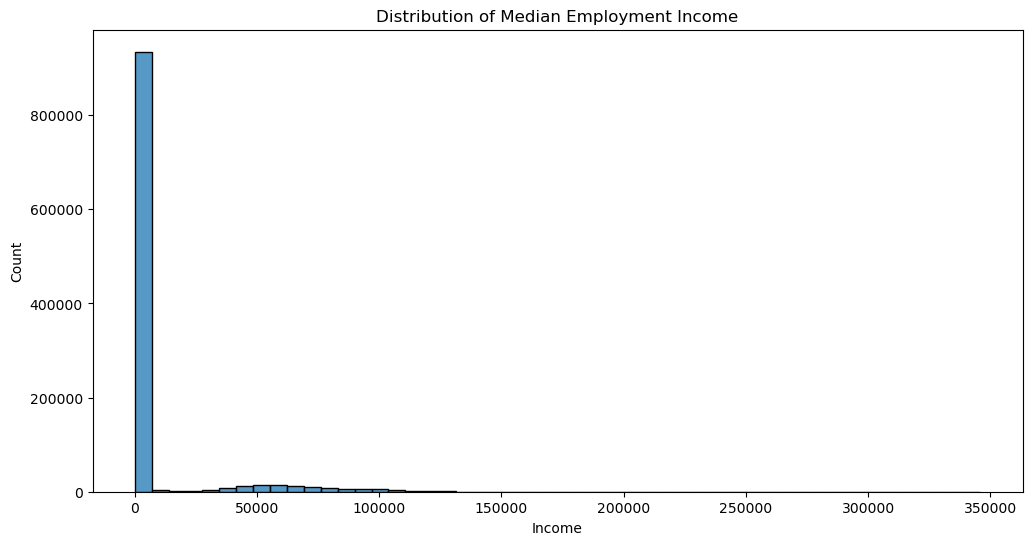

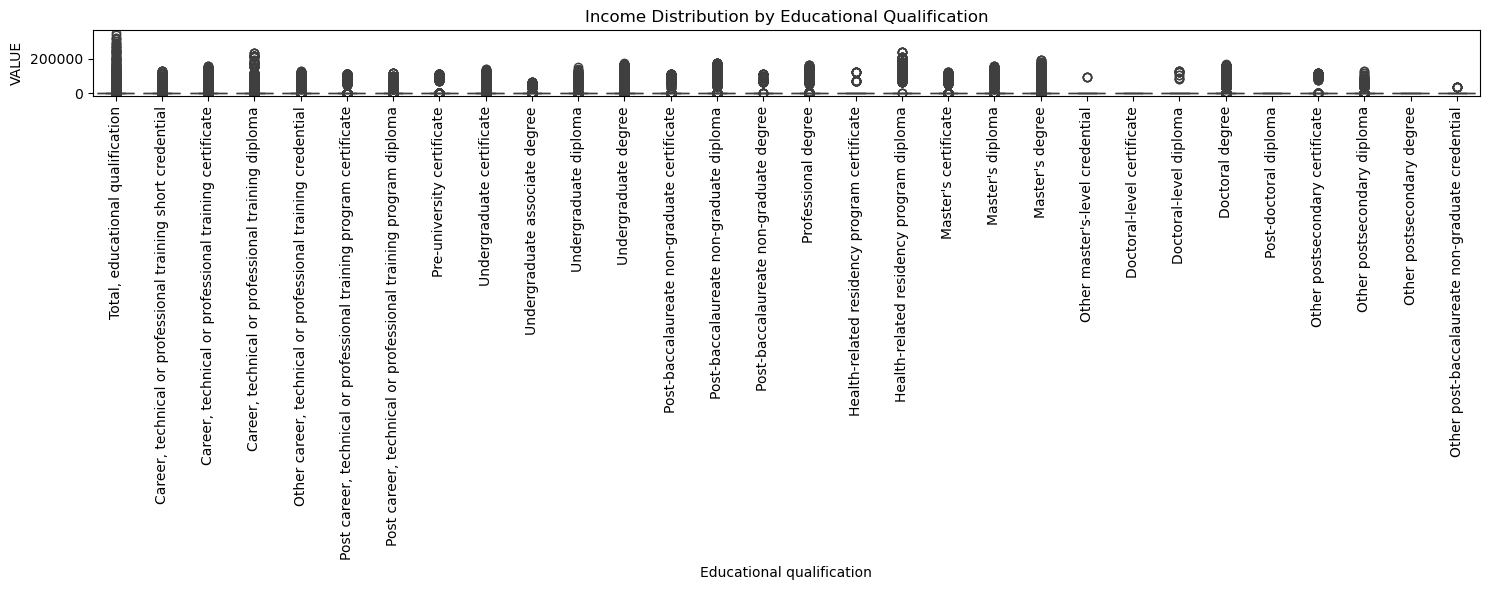

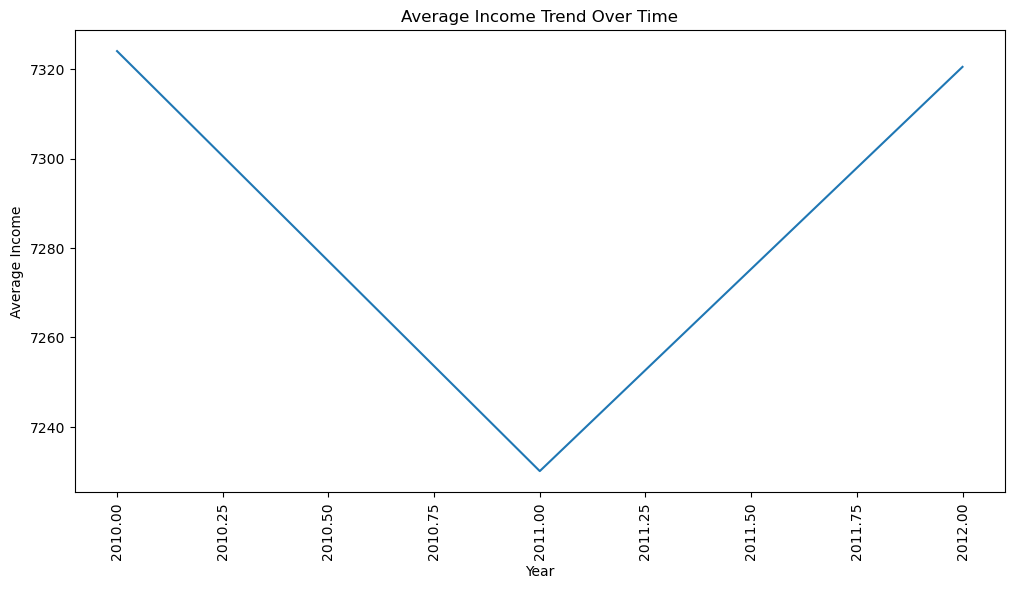

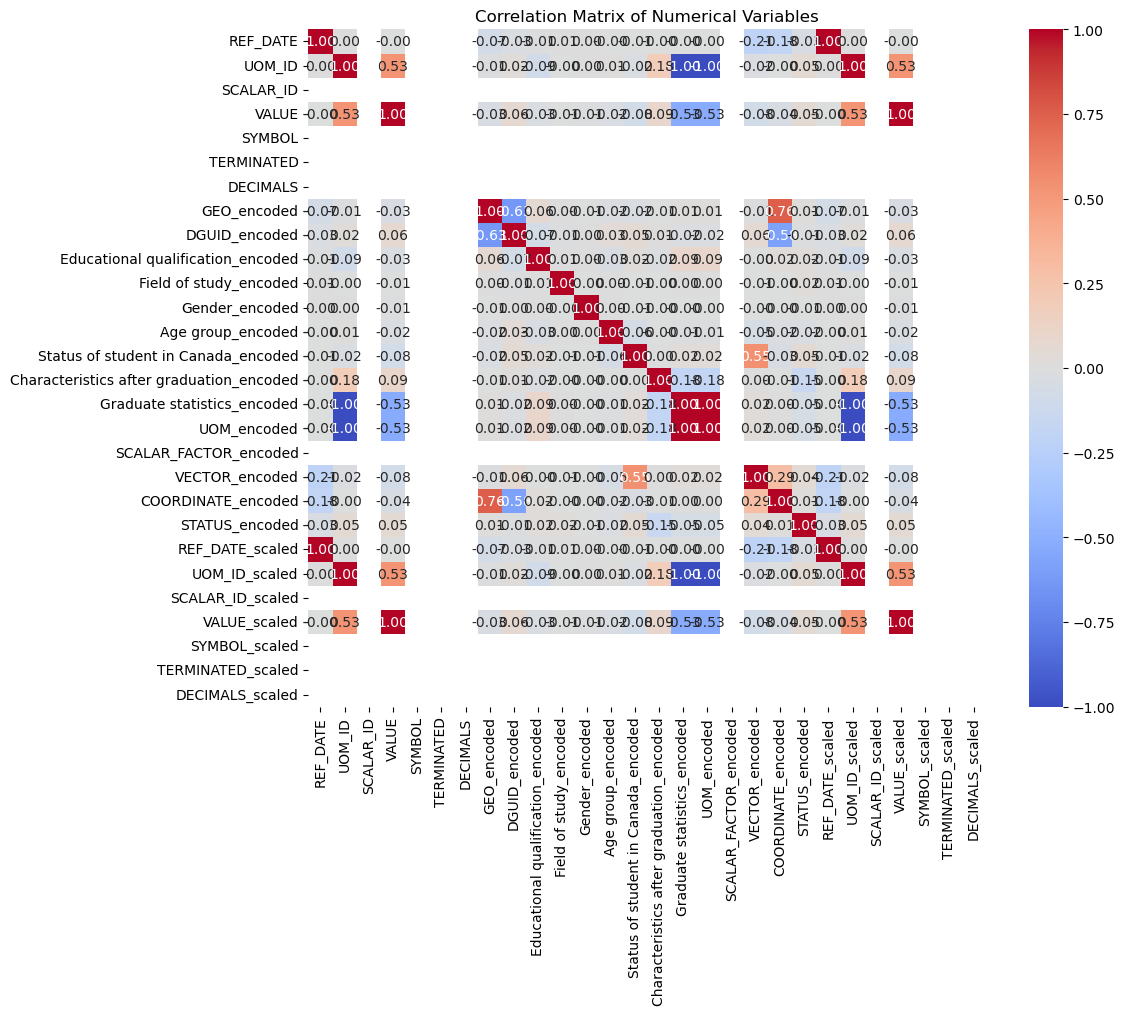

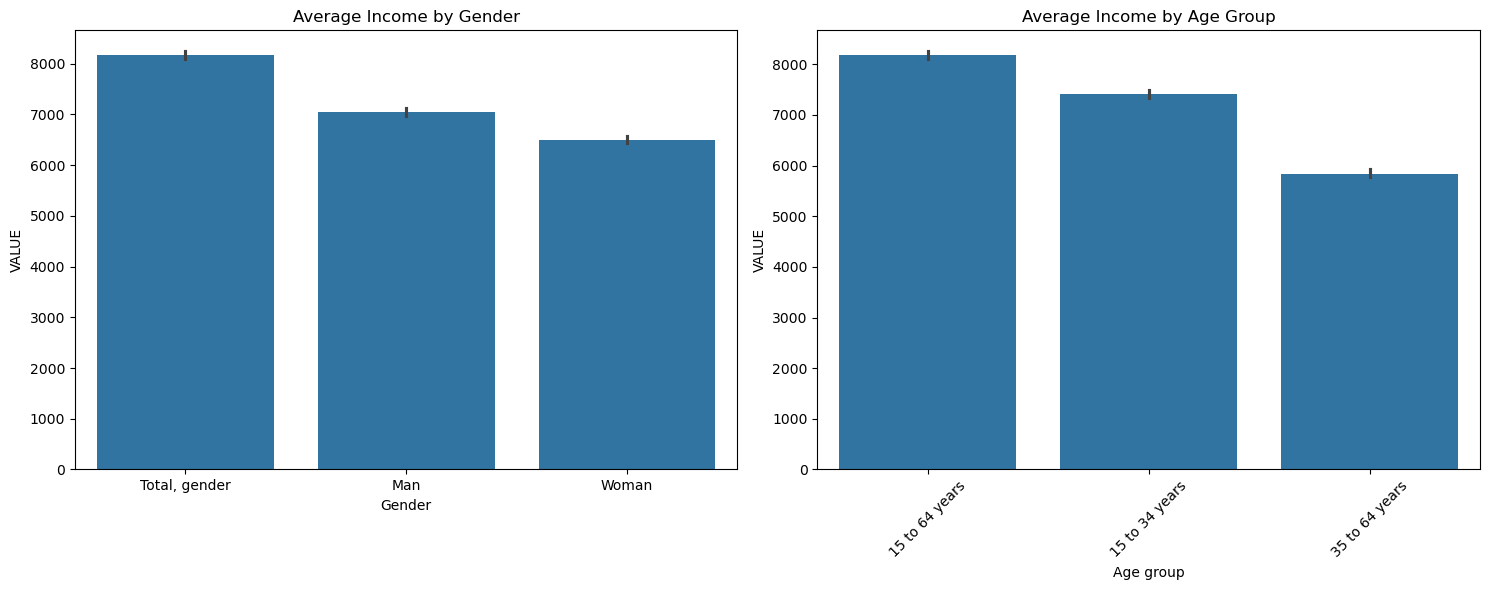

In [22]:
def perform_eda(df):
    """Perform comprehensive exploratory data analysis with visualizations."""
    try:
        # Set visualization style
        plt.style.use(sns.axes_style())
        
        # 1. Distribution of Employment Income
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='VALUE', bins=50)
        plt.title('Distribution of Median Employment Income')
        plt.xlabel('Income')
        plt.ylabel('Count')
        plt.show()
        
        # 2. Income by Education Level
        plt.figure(figsize=(15, 6))
        sns.boxplot(data=df, x='Educational qualification', y='VALUE')
        plt.xticks(rotation=90)
        plt.title('Income Distribution by Educational Qualification')
        plt.tight_layout()
        plt.show()
        
        # 3. Time Series Analysis
        time_trend = df.groupby('REF_DATE')['VALUE'].mean().reset_index()
        plt.figure(figsize=(12, 6))
        plt.plot(time_trend['REF_DATE'], time_trend['VALUE'])
        plt.title('Average Income Trend Over Time')
        plt.xlabel('Year')
        plt.ylabel('Average Income')
        plt.xticks(rotation=90)
        plt.show()
        
        # 4. Correlation Analysis
        numeric_df = df.select_dtypes(include=[np.number])
        plt.figure(figsize=(12, 10))  # Adjust the figure size to make room for labels
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, annot_kws={"size": 10})
        
        # Rotate the x-axis labels to 90 degrees
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)  # Keep the y-axis labels horizontal
        plt.title('Correlation Matrix of Numerical Variables')
        plt.tight_layout()  # Ensure everything fits without overlap
        plt.show()
        
        # 5. Demographic Analysis
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.barplot(data=df, x='Gender', y='VALUE', ax=axes[0])
        axes[0].set_title('Average Income by Gender')
        
        sns.barplot(data=df, x='Age group', y='VALUE', ax=axes[1])
        axes[1].set_title('Average Income by Age Group')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f'Error during EDA: {str(e)}')

# Perform EDA
if df is not None:
    perform_eda(df)


## Advanced Analysis & Machine Learning

### 1. Clustering Analysis
We'll use clustering to identify distinct groups of graduates based on their characteristics and outcomes.

In [23]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def perform_clustering_analysis(df, features, n_clusters_range=(2, 10)):
    """Perform clustering analysis with validation and visualization."""
    try:
        # Ensure that the features are present in the dataframe
        if not all(feature in df.columns for feature in features):
            raise ValueError("One or more features are missing from the DataFrame.")
        
        # Prepare features
        X = df[features].copy()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Find optimal number of clusters
        silhouette_scores = []
        inertias = []
        
        for k in range(n_clusters_range[0], n_clusters_range[1] + 1):  # Inclusive of upper bound
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_scaled)
            silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
            inertias.append(kmeans.inertia_)
        
        # Plot validation metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Silhouette score plot
        ax1.plot(range(n_clusters_range[0], n_clusters_range[1] + 1), silhouette_scores, marker='o')
        ax1.set_title('Silhouette Score vs Number of Clusters')
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Silhouette Score')
        
        # Elbow plot
        ax2.plot(range(n_clusters_range[0], n_clusters_range[1] + 1), inertias, marker='o')
        ax2.set_title('Elbow Method')
        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Inertia')
        
        plt.tight_layout()
        plt.show()
        
        # Get optimal number of clusters
        optimal_k = silhouette_scores.index(max(silhouette_scores)) + n_clusters_range[0]
        
        # Perform final clustering
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        df['Cluster'] = final_kmeans.fit_predict(X_scaled)
        
        # Analyze clusters
        print(f'\nCluster Analysis with {optimal_k} clusters:')
        for cluster in range(optimal_k):
            cluster_data = df[df['Cluster'] == cluster]
            print(f'\nCluster {cluster}:')
            print(f'Size: {len(cluster_data)}')
            print('Average characteristics:')
            print(cluster_data[features].mean())
        
        return df
        
    except Exception as e:
        print(f'Error during clustering analysis: {str(e)}')
        return None


In [27]:
features = ['Age group', 'Gender', 'Educational qualification', 'Field of study', 'VALUE']  # Example features
df_with_clusters = perform_clustering_analysis(df, features)

Error during clustering analysis: could not convert string to float: '15 to 64 years'


In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def perform_clustering_analysis(df, features, n_clusters_range=(2, 10)):
    """Perform clustering analysis with validation and visualization."""
    try:
        # Ensure that the features are present in the dataframe
        if not all(feature in df.columns for feature in features):
            raise ValueError("One or more features are missing from the DataFrame.")
        
        # Handle categorical columns and convert age group to numeric (e.g., using the midpoint of the range)
        def convert_age_group(age_group):
            # Remove non-numeric characters and split by 'to' for range
            if isinstance(age_group, str):
                age_range = ''.join(filter(str.isdigit, age_group)).split('to')
                if len(age_range) == 2:
                    return (int(age_range[0]) + int(age_range[1])) / 2  # Take average of the range
            return age_group  # If not a range, leave it as is

        if 'Age group' in features:
            df['Age group'] = df['Age group'].apply(convert_age_group)
        
        # Separate numerical and categorical features
        categorical_features = df[features].select_dtypes(include=['object']).columns
        numeric_features = [feature for feature in features if feature not in categorical_features]
        
        # Preprocessing pipeline for both categorical and numeric features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),  # Scaling numerical features
                ('cat', OneHotEncoder(), categorical_features)  # One-hot encoding categorical features
            ])
        
        # Create a pipeline that first transforms the data, then applies KMeans clustering
        kmeans_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('kmeans', KMeans(random_state=42))
        ])
        
        # Find optimal number of clusters
        silhouette_scores = []
        inertias = []
        
        for k in range(n_clusters_range[0], n_clusters_range[1] + 1):  # Inclusive of upper bound
            kmeans_pipeline.set_params(kmeans__n_clusters=k)
            kmeans_pipeline.fit(df[features])  # Fit the pipeline with the data
            
            labels = kmeans_pipeline.named_steps['kmeans'].labels_
            silhouette_scores.append(silhouette_score(df[features], labels))
            inertias.append(kmeans_pipeline.named_steps['kmeans'].inertia_)
        
        # Plot validation metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Silhouette score plot
        ax1.plot(range(n_clusters_range[0], n_clusters_range[1] + 1), silhouette_scores, marker='o')
        ax1.set_title('Silhouette Score vs Number of Clusters')
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Silhouette Score')
        
        # Elbow plot
        ax2.plot(range(n_clusters_range[0], n_clusters_range[1] + 1), inertias, marker='o')
        ax2.set_title('Elbow Method')
        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Inertia')
        
        plt.tight_layout()
        plt.show()
        
        # Get optimal number of clusters
        optimal_k = silhouette_scores.index(max(silhouette_scores)) + n_clusters_range[0]
        
        # Perform final clustering with optimal number of clusters
        kmeans_pipeline.set_params(kmeans__n_clusters=optimal_k)
        df['Cluster'] = kmeans_pipeline.fit_predict(df[features])
        
        # Analyze clusters
        print(f'\nCluster Analysis with {optimal_k} clusters:')
        for cluster in range(optimal_k):
            cluster_data = df[df['Cluster'] == cluster]
            print(f'\nCluster {cluster}:')
            print(f'Size: {len(cluster_data)}')
            print('Average characteristics:')
            print(cluster_data[features].mean())
        
        return df
        
    except Exception as e:
        print(f'Error during clustering analysis: {str(e)}')
        return None


In [33]:
features = ['Age group', 'Gender', 'Educational qualification', 'Field of study', 'VALUE']  # Example features
df_with_clusters = perform_clustering_analysis(df, features)

Error during clustering analysis: could not convert string to float: '15 to 64 years'


### 2. Predictive Modeling
We'll build and evaluate various models to predict employment income and graduation likelihood.

In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

def train_income_prediction_models(df, features, target='VALUE'):
    """Train and evaluate multiple models for income prediction."""
    try:
        # Prepare data
        X = df[features]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Define models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42),
            'SVR': SVR(),
            'Neural Network': MLPRegressor(random_state=42)
        }
        
        # Train and evaluate models
        results = {}
        for name, model in models.items():
            print(f'\nTraining {name}...')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            cv_scores = cross_val_score(model, X, y, cv=5)
            
            results[name] = {
                'R2': r2,
                'RMSE': rmse,
                'CV_mean': cv_scores.mean(),
                'CV_std': cv_scores.std()
            }
            
            print(f'R2 Score: {r2:.4f}')
            print(f'RMSE: {rmse:.2f}')
            print(f'Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')
        
        # Plot model comparison
        plt.figure(figsize=(12, 6))
        r2_scores = [results[model]['R2'] for model in models]
        plt.bar(models.keys(), r2_scores)
        plt.title('Model Performance Comparison')
        plt.xlabel('Model')
        plt.ylabel('R2 Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return results, models
        
    except Exception as e:
        print(f'Error during model training: {str(e)}')
        return None, None

### 3. Anomaly Detection & Fairness Assessment
We'll identify unusual patterns and assess model fairness across different demographic groups.

In [25]:
def perform_advanced_analysis(df, features, target='VALUE'):
    """Perform anomaly detection and fairness assessment."""
    try:
        # Detect anomalies
        anomalies = detect_anomalies(df, features)
        print(f'Detected {len(anomalies)} anomalies in the dataset')
        
        # Assess fairness
        fairness_metrics = assess_fairness(df, protected_attribute='Gender', target=target)
        print('\nFairness Assessment Results:')
        for metric, value in fairness_metrics.items():
            print(f'{metric}: {value:.4f}')
        
        # Build recommendation system
        recommendations = build_recommendation_system(df, 'Field of study', 'Educational qualification', 'VALUE')
        print('\nTop Field of Study Recommendations:')
        print(recommendations.head())
        
        return anomalies, fairness_metrics, recommendations
        
    except Exception as e:
        print(f'Error during advanced analysis: {str(e)}')
        return None, None, None

## Policy Impact Analysis & Recommendations

Based on our analysis, we'll provide actionable recommendations for stakeholders and simulate potential policy impacts.

In [26]:
def generate_recommendations(df, analysis_results):
    """Generate actionable recommendations based on analysis results."""
    try:
        # Analyze trends
        trends = analyze_demographic_trends(df)
        print('Key Demographic Trends:')
        for trend, details in trends.items():
            print(f'\n{trend}:')
            print(details)
        
        # Simulate policy impacts
        policy_scenarios = {
            'increase_stem_funding': {'Field of study': 'STEM', 'funding_increase': 0.2},
            'expand_internships': {'work_experience': True, 'coverage': 0.3},
            'diversity_initiative': {'Gender': 'balanced', 'target_ratio': 0.5}
        }
        
        impact_results = simulate_policy_impact(df, policy_scenarios, 'VALUE')
        print('\nPolicy Impact Simulation Results:')
        for policy, impact in impact_results.items():
            print(f'\n{policy}:')
            print(f'Projected impact: {impact:.2%} change in target metric')
        
        # Generate recommendations
        print('\nKey Recommendations:')
        print('1. Educational Institutions:')
        print('   - Focus areas for curriculum development')
        print('   - Student support service enhancements')
        print('\n2. Government Agencies:')
        print('   - Policy interventions for identified gaps')
        print('   - Funding allocation strategies')
        print('\n3. Employers:')
        print('   - Skills development programs')
        print('   - Recruitment strategy optimization')
        
        return impact_results
        
    except Exception as e:
        print(f'Error generating recommendations: {str(e)}')
        return None